# This notebook is to cluster Relative information density can cluster RBPs based on their known function
## Load Precomputed Density

In [5]:
import deepdish as dd
import os
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# let's just load 1 example 
base_dir = '/home/hsher/densities'


In [6]:
# find proteins with density precomputed
uids = [f.split('_')[0] for f in os.listdir(base_dir) if 'truncatearr' in f]

with_data = master_df.set_index('uid').loc[uids]

In [3]:
hepg2_uids = with_data.loc[with_data['Cell line'] == 'HepG2']
hepg2_uids.drop_duplicates(subset = ['RBP'], inplace = True)
k562_uids = with_data.loc[with_data['Cell line'] == 'K562']
k562_uids.drop_duplicates(subset = ['RBP'], inplace = True)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Generic RNA metadensity
The features of interest are `['first_exon', 'exon', 'intron', 'last_exon']`

# Load density probability distribution

In [4]:
from annoloader import *
from heatmap_util import *


Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


In [ ]:
def get_feat_ticks():
    ''' generic_rna''':
    

In [25]:
def get_map(df, colors, names, rbp_class_color = rbp_class_color, vmax = 0.1, vmin = 0, 
            colorbar_lbl = 'Normalized Subtracted Metadensity', figsize=(10, 10)):
    df = df.loc[df.sum(axis = 1)>0] # only those with significant data
    
    cmap = sns.cubehelix_palette(8, start=7, rot=0, dark=0, light=.95, as_cmap=True)
    g = sns.clustermap(df, 
                   metric ="correlation", method = "complete",
                   row_cluster = True,  row_colors = rbp_class_color,
                   col_cluster = False, col_colors = colors,
                   yticklabels=1,z_score = 0,
                   figsize=figsize, cmap = cmap, cbar_pos=(0.95, .2, .03, .4),
                       colors_ratio = 0.015, vmax = vmax, vmin = vmin,
                      cbar_kws = {'label': colorbar_lbl})
    g.ax_heatmap.set_ylabel('RBPs')
    g.ax_heatmap.set_xlabel('metagene position')

    for label in names:
        g.ax_row_dendrogram.bar(0, 0, color=color_dict[label],
                            label=label, linewidth=0)
    g.ax_row_dendrogram.legend(loc="best", bbox_to_anchor=(1.1, 0), ncol=1)
    
    return g
    

# Make 1 map of RNA, remove RBPs with no intron signals

In [6]:
df, flen = into_one_df(hepg2_uids.index.tolist()+k562_uids.index.tolist(), generic_rna, suffix = 'truncatearr', stat = np.nanmedian)
rna_color, names = get_feat_color(generic_rna, flen)



/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [7]:
intron_start = flen['first_exon']*2+flen['exon']*2
intron_end = intron_start + flen['intron']*2

<AxesSubplot:>

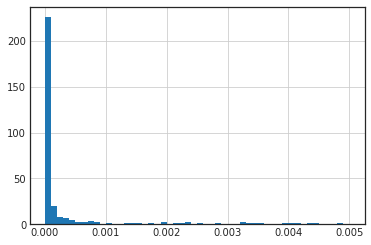

In [8]:
%matplotlib inline
df.loc[:, intron_start:intron_end].sum(axis = 1).hist(range = (0,0.005), bins = 50)

In [9]:
df.index = master_df.set_index('uid').loc[df.index, 'RBP']

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/seaborn-0.11.0-py3.7.egg/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


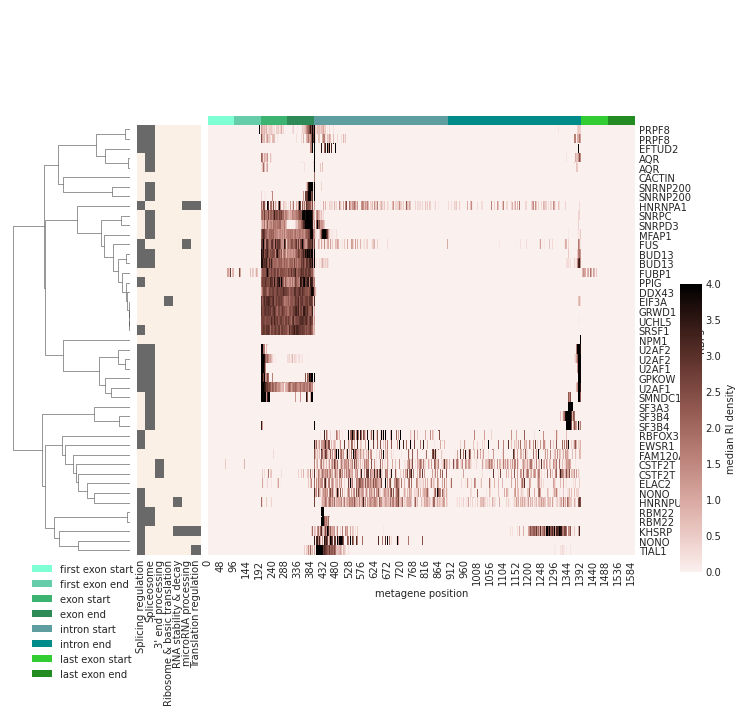

In [10]:
# set index to RBP

g_rna = get_map(df.loc[df[list(range(intron_start, intron_end))].sum(axis = 1)>0.0005], 
        rna_color, names, rbp_class_color = rbp_class_color[subset], 
        vmax = 4, colorbar_lbl = 'median RI density')

/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


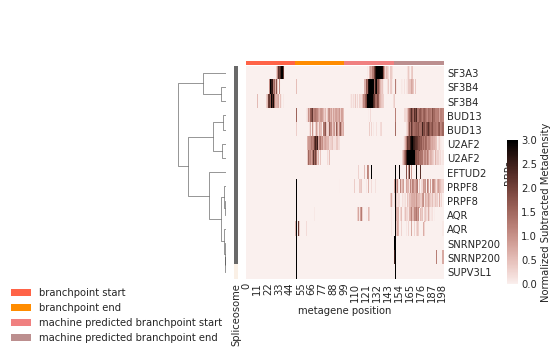

In [29]:
df, flen = into_one_df(k562_uids.index.tolist()+hepg2_uids.index.tolist(),branchpoints, suffix = 'truncatearr', stat = np.nanmedian)
rna_color, names = get_feat_color(branchpoints, flen)
df.index = master_df.set_index('uid').loc[df.index, 'RBP']
get_map(df.loc[(df.iloc[:,40:60].ge(0.00005).any(axis = 1))|(df.iloc[:,140:160].ge(0.00005).any(axis = 1))], rna_color, names, rbp_class_color = rbp_class_color['Spliceosome'],
        vmax = 3, figsize = (5,5))

# Highlight specific groups of protein in branchpoint

In [12]:
def load_metadensity(uid, basedir = base_dir, suffix='ridensityarr',
                     background_method = 'relative information', normalize = False):
    ''' load it back so we can use the plotting function from metadensity'''
    
    try:
        row = encode4_data.loc[encode4_data['uid']==uid].iloc[0]
        e = eCLIP.from_series(row, single_end = True)
        cell_line = row['Cell line']
    except:
        row = encode_data.loc[encode_data['uid']==uid].iloc[0]
        e = eCLIP.from_series(row)
        cell_line = row['Cell line']
    
    den = Metadensity(e, name = f'{e.name}({cell_line})' , 
                        deep_dish_path = os.path.join(basedir, f'{uid}_{suffix}.h5'),
                        background_method = background_method, normalize = normalize)
    return den
    

In [13]:
def get_rbp_colors(all_meta):
    rbps = [n.name.split('(')[0] for n in all_meta]
    rbps.sort()
    colors = auto_rbp_color(rbps)
    # remap
    color_dict = {}
    for m in all_meta:
        color_dict[m.name] = colors[m.name.split('(')[0]]
    return color_dict

In [23]:
flen

{'exon': 100,
 'branchpoint_pred': 50,
 'three_prime_UTR': 150,
 'last_exon': 100,
 'polyAsignal': 50,
 'polyAsite': 50,
 'CDS': 100,
 'branchpoint': 50,
 'last_CDS': 100,
 'first_CDS': 100,
 'five_prime_UTR': 100,
 'first_exon': 100,
 'intron': 500,
 'full_CDS': 200}

In [14]:
# screen for all branch binding proteins
df, flen = into_one_df(hepg2_uids.index.tolist()+k562_uids.index.tolist(),branchpoints, suffix = 'ridensityarr', stat = np.nanmedian)

brs = df.loc[(df.iloc[:,30:70].ge(0.00005).any(axis = 1))|(df.iloc[:,130:170].ge(0.00005).any(axis = 1))].index

/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


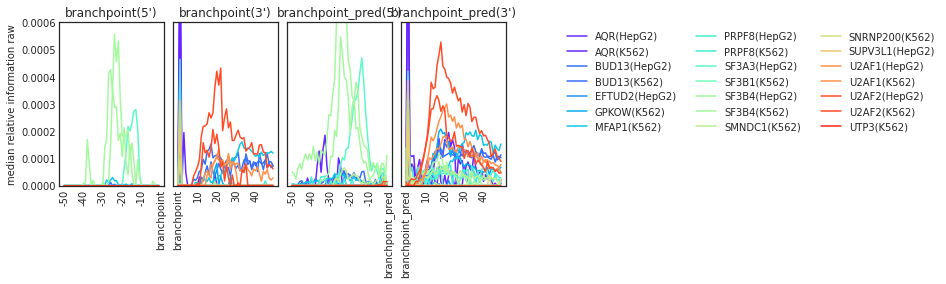

In [15]:
all_meta = sorted([load_metadensity(uid, suffix = 'truncatearr') for uid in brs], key = lambda x: x.name)

f = plot_mean_density(all_meta, smooth = False, features_to_show=branchpoints, stat = 'median', ymax = 0.0006, plot_std = False, color_dict = get_rbp_colors(all_meta))

# PolyA binding protein

/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/seaborn-0.11.0-py3.7.egg/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


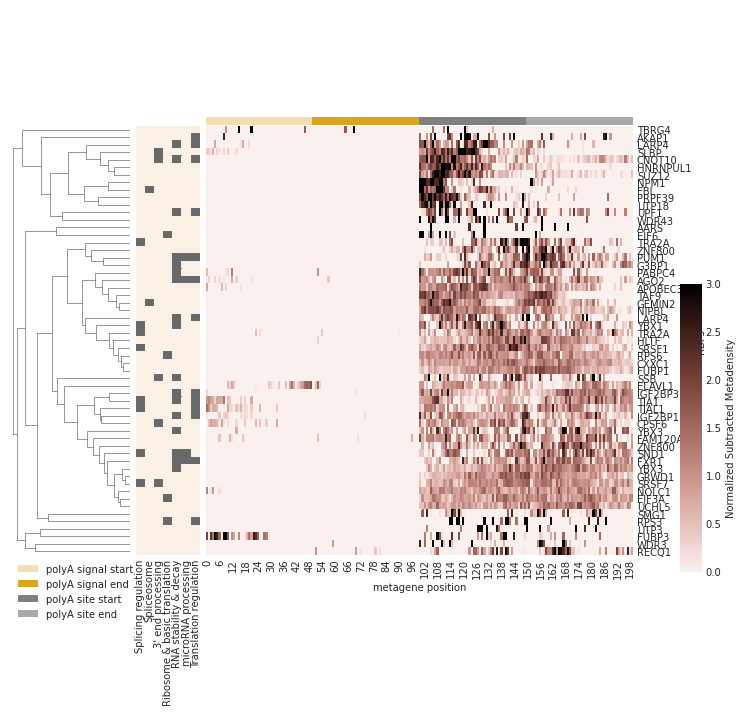

In [16]:
df, flen = into_one_df(k562_uids.index.tolist()+hepg2_uids.index.tolist(),polyAs, suffix = 'truncatearr', stat = np.nanmedian)
rna_color, names = get_feat_color(polyAs, flen)
df.index = master_df.set_index('uid').loc[df.index, 'RBP']
get_map(df.loc[(df.iloc[:,30:70].ge(0.00005).any(axis = 1))|(df.iloc[:,130:170].ge(0.00005).any(axis = 1))], rna_color, names, rbp_class_color = rbp_class_color[subset], vmax = 3)

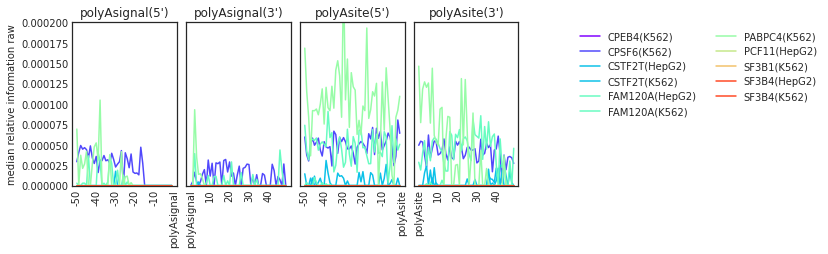

In [22]:
polya = ['PABPC4', 'CPEB4', 'FAM120A', 'PCF11', 'SF3B1', 'SF3B4', 'CSTF2T', 'CPSF6']
polya_uids = master_df.loc[master_df['RBP'].isin(polya), 'uid'].to_list()

all_meta = sorted([load_metadensity(uid, suffix = 'truncatearr') for uid in polya_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=polyAs, stat = 'median', ymax = 0.0002, plot_std = False, color_dict = get_rbp_colors(all_meta))

# translation

In [18]:
protein_coding_2 = ['five_prime_UTR', 'full_CDS', 'three_prime_UTR']

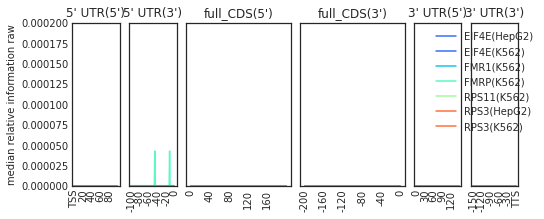

In [19]:
polya = ['RPS3', 'RPS5', 'RPS11', 'FMR1', 'FMRP', 'FXR', 'EIF4E']
polya_uids = master_df.loc[master_df['RBP'].isin(polya), 'uid'].to_list()

all_meta = sorted([load_metadensity(uid, suffix = 'truncatearr') for uid in polya_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=protein_coding_2, stat = 'median', ymax = 0.0002, plot_std = False, color_dict = get_rbp_colors(all_meta))

In [20]:
flen

{'exon': 100,
 'branchpoint_pred': 50,
 'three_prime_UTR': 150,
 'last_exon': 100,
 'polyAsignal': 50,
 'polyAsite': 50,
 'CDS': 100,
 'branchpoint': 50,
 'last_CDS': 100,
 'first_CDS': 100,
 'five_prime_UTR': 100,
 'first_exon': 100,
 'intron': 500,
 'full_CDS': 200}

In [21]:
df, flen = into_one_df(k562_uids.index.tolist()+hepg2_uids.index.tolist(),protein_coding_2, suffix = 'truncatearr', stat = np.nanmedian)
rna_color, names = get_feat_color(protein_coding_2, flen)


/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
